In [209]:
import pandas as pd
import os
from unit_conversion import convert_wind
from scipy.interpolate import CubicSpline
from puff_model_optimized import puff_model
from puff_inverse_model_optimized import puff_inverse_model
import torch
import numpy as np

### Pull Data

In [210]:
data_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\data'
sensor_data = pd.read_csv(f'{data_path}\\background_removed_measured_ch4.csv')
emissions_data = pd.read_csv(f'{data_path}\\emission_data_processed.csv').drop_duplicates()
sensor_locations = pd.read_csv(f'{data_path}\\ADED_sensor_locations.csv')
source_locations = pd.read_csv(f'{data_path}\\ADED_source_locations.csv')
wind_data = pd.read_csv(f'{data_path}\\METEC_2024_Separator.West_simulation.csv')[['time_stamp.MT','wind_speed.MS','wind_direction']] # from data_for_michael


In [211]:
emissions_data['start_time'] = pd.to_datetime(emissions_data.start_time)
emissions_data['end_time'] = pd.to_datetime(emissions_data.end_time)
emissions_data['start_time_seconds'] = pd.to_datetime(emissions_data.start_time).map(pd.Timestamp.timestamp)
start_time_utc_seconds = emissions_data.start_time_seconds.min()
emissions_data.start_time_seconds -= start_time_utc_seconds
emissions_data['end_time_seconds'] =   pd.to_datetime(emissions_data.end_time).map(pd.Timestamp.timestamp) - start_time_utc_seconds
emissions_data = emissions_data.astype({'source':'str'})
# Need (0,2),(2,6), but won't get it.
# emissions_data = pd.DataFrame({"start_time_seconds": [0,2,2,4,8,10], "end_time_seconds" : [6,5,4,6,10,12] })
# check next start time value, see if it lies in data point's interval. If so, split
while True:
    emissions_data = emissions_data.sort_values('start_time_seconds')
    emissions_data['shifted_start'] = emissions_data.start_time_seconds.shift(-1).fillna(1e10)
    emissions_data['shifted_start'] = emissions_data.groupby('start_time_seconds')['shifted_start'].transform('max')
    emissions_data['bool'] =  (emissions_data.shifted_start != emissions_data.start_time_seconds) & (emissions_data.shifted_start < emissions_data.end_time_seconds)
    temp1 = emissions_data[emissions_data['bool'] == True].copy()
    temp2 = temp1.copy()
    temp1['end_time_seconds'] = temp1['shifted_start']
    temp2['start_time_seconds'] = temp2['shifted_start']
    emissions_data = pd.concat([emissions_data[emissions_data['bool'] == False],temp1,temp2])
    if emissions_data['bool'].sum() == 0:
        break
#GIVEN all start points align, this works for the other side. Make sure different end - times have their respective intervals. ex: (4,6), (4,7) -> (4,6),(4,6),(6,7)
emissions_data['window_end'] = emissions_data.groupby('start_time_seconds')['end_time_seconds'].transform('min')
while True:
    if (emissions_data.window_end - emissions_data.end_time_seconds).sum() == 0:
        break
    temp = emissions_data[emissions_data.window_end != emissions_data.end_time_seconds].copy()
    temp.start_time_seconds = temp.window_end
    temp['window_end'] = temp.groupby('start_time_seconds')['end_time_seconds'].transform('min')
    emissions_data['end_time_seconds'] = emissions_data.window_end
    emissions_data = pd.concat([emissions_data,temp])

emissions_data = emissions_data.sort_values('start_time_seconds')
emissions_data = emissions_data.groupby(['start_time_seconds','end_time_seconds']).agg(list).reset_index()
emissions_data = emissions_data[['start_time_seconds','end_time_seconds','source','emission_rate']]
emissions_data['duration'] = emissions_data.end_time_seconds - emissions_data.start_time_seconds
emissions_data['num_active_sources'] = emissions_data.source.apply(lambda x : len(x))
emissions_data['contains_na'] = emissions_data.source.apply(lambda x : 'nan' in "".join(x))


In [212]:
sensor_data['time_stamp'] = pd.to_datetime(sensor_data.time_stamp)
sensor_data['time_stamp_seconds'] = pd.to_datetime(sensor_data.time_stamp).map(pd.Timestamp.timestamp)
sensor_data.time_stamp_seconds -= start_time_utc_seconds
print(sensor_locations)

     easting    northing  height name  Decimal_Latitude  Decimal_Longitude
0  488225.64  4493892.25     2.4    E         40.595749        -105.139155
1  488187.23  4493898.19     2.4   E1         40.595802        -105.139609
2  488217.15  4493929.89     2.4  ENE         40.596088        -105.139256
3  488174.85  4493930.40     2.4  NNE         40.596092        -105.139756
4  488166.87  4493862.81     2.4    S         40.595483        -105.139849
5  488216.70  4493859.41     2.4   SE         40.595453        -105.139260
6  488124.06  4493862.77     2.4   SW         40.595482        -105.140355
7  488105.33  4493899.10     2.4    W         40.595809        -105.140577
8  488142.73  4493898.93     2.4   W1         40.595808        -105.140135
9  488102.76  4493931.52     2.4  WNW         40.596101        -105.140608


In [213]:
# source_locations['easting'] = -1*source_locations['easting']
# sensor_locations['easting'] = -1*sensor_locations['easting']

min_east = min([source_locations.easting.min(),sensor_locations.easting.min()])
min_north = min([source_locations.northing.min(),sensor_locations.northing.min()])

source_locations['easting'] -= min_east - 5
source_locations['northing'] -= min_north - 5

sensor_locations['easting'] -= min_east - 5
sensor_locations['northing'] -= min_north - 5

In [214]:
exclude = ['E1','W1']


In [215]:
source_points = torch.tensor(source_locations[['easting','northing','height']].to_numpy())
sensor_points = torch.tensor(sensor_locations[['easting','northing','height']].to_numpy())
source_names = source_locations['name'].to_numpy()
sensor_names = sensor_locations['name'].to_numpy()
num_sensors = len(sensor_names)

In [216]:
wind_data['time_stamp'] = pd.to_datetime(wind_data['time_stamp.MT'],utc=True)
wind_data['time_stamp_seconds'] = wind_data['time_stamp'].map(pd.Timestamp.timestamp) - start_time_utc_seconds

In [217]:
wind_data['x'], wind_data['y'] = convert_wind(wind_data['wind_speed.MS'],wind_data['wind_direction'])
wind_x = lambda t : torch.tensor(CubicSpline(wind_data['time_stamp_seconds'],wind_data.x)(t))
wind_y = lambda t : torch.tensor(CubicSpline(wind_data['time_stamp_seconds'],wind_data.y)(t))

In [218]:
sensor_values_fn = dict()
for name in sensor_names:
    sensor_values_fn[name] = lambda t, f = CubicSpline(sensor_data['time_stamp_seconds'], sensor_data[name]) : torch.tensor(f(t))

In [219]:
# num_obs = 45
# tbegin = 0*60
# tend = 45*60
# obs_t = torch.linspace(tbegin,tend,num_obs).reshape(-1,1)
# obs = torch.zeros(num_obs, num_sensors)
# obs += torch.rand(obs.shape)*0
# for i in range(num_obs):
#     for j in range(num_sensors):
#         obs[i,j] = torch.tensor(sensor_values_fn[sensor_names[j]](obs_t[i].item()))
# obs = obs.T.reshape(-1,1)
# obs_x = torch.tile(torch.tensor(sensor_points_filtered).reshape(-1,1,3),(1,obs_t.shape[0],1)).reshape(-1,3)
# obs_t = obs_t.repeat(num_sensors,1)

In [220]:
def run_sim_range(start, end, num_nz, wind_x, wind_y):
    tt = torch.linspace(start,end,100).reshape(-1,1)
    obs = torch.cat([sensor_values_fn[sensor_names[i]](tt) for i in range(len(sensor_names))])
    obs_x = torch.tile(sensor_points.reshape(-1,1,3),(1,tt.shape[0],1)).reshape(-1,3)
    obs_t = tt.repeat(num_sensors,1) 
    pm = puff_model(source_points, sensor_points, [3, 3, 1], wind_x, wind_y,[1,1],1,spread=True,t0=start, t_max=end)
    pim = puff_inverse_model(pm)
    x = pim.solve_inverse_problem(obs_x, obs_t, obs, num_nz = num_nz, bias_terms = 1, weights=None)
    return x, pim

In [221]:
print(source_points.shape)

torch.Size([5, 3])


In [225]:
test_num = 26
experiment_55min_1src = emissions_data[(emissions_data.duration >= 55*60) & (emissions_data.num_active_sources == 1) & (emissions_data.contains_na == False)]
print(len(experiment_55min_1src))
test = experiment_55min_1src.reset_index().loc[test_num,:]
x,pim = run_sim_range(test.start_time_seconds,test.end_time_seconds,1,wind_x,wind_y)
pm = pim.pm


88


In [226]:
print(source_names)
print(test['source'])
print(x)

['Tank' 'Separator.East' 'Wellhead.East' 'Wellhead.West' 'Separator.West']
['Wellhead.West']
tensor([[-8.8660e-10],
        [ 1.0954e-10],
        [ 6.6553e-10],
        [ 1.9244e+03],
        [-2.5809e-09],
        [ 3.2948e-07]])


In [224]:
for j in range(0,1):
    ls = []
    ls1=[]
    num_sources = j + 1
    num_minutes = 10
    sample = emissions_data[(emissions_data.duration >= num_minutes*60) & (emissions_data.num_active_sources == num_sources) & (emissions_data.contains_na == False)].copy()
    print('number of data points that match criteria:', len(sample))
    for i in range(len(sample)):
        row = sample.reset_index().loc[i,:]
        x,pim = run_sim_range(row.start_time_seconds,row.end_time_seconds,num_sources,wind_x,wind_y)
        # x = torch.round(x,decimals=8)
        _,nz = np.array(torch.topk(x[:-1].reshape(-1),k=num_sources)).astype(int)
        # nz = np.delete(nz, np.where(nz == 5))
        ls.append(np.mean(np.sort(source_names[nz])==np.sort(row['source'])) == 1)
        ls1.append(np.sort(source_names[nz]))
        print(ls1[-1], row['source'])
        print(ls[-1])
        # print(np.sort(source_names[nz[:-1]])==np.sort(row['source']))
    sample['prediction_correct'] = ls
    sample['prediction'] = ls1
    sample.to_csv(f'simulation_output_{num_sources}_sources_time_.csv')

number of data points that match criteria: 124
['Separator.East'] ['Wellhead.West']
False
['Separator.East'] ['Separator.East']
True
['Wellhead.West'] ['Wellhead.West']
True
['Wellhead.West'] ['Wellhead.West']
True
['Wellhead.West'] ['Wellhead.West']
True
['Tank'] ['Tank']
True
['Wellhead.West'] ['Wellhead.West']
True
['Tank'] ['Tank']
True
['Tank'] ['Tank']
True
['Tank'] ['Tank']
True
['Separator.West'] ['Separator.West']
True
['Tank'] ['Tank']
True


KeyboardInterrupt: 

In [227]:
num_t = 10
num_xy = 50

X,Y,Z = torch.meshgrid(torch.linspace(0,130,num_xy),torch.linspace(0,80,num_xy),torch.tensor([2.4]),indexing='xy')
XX = torch.cat([X.reshape(-1,1),Y.reshape(-1,1),Z.reshape(-1,1)],dim=1).repeat(num_t,1)
# x = pim.solve_inverse_problem_base(obs, obs_t, num_nz = 1, weights = None)
t_linspace = torch.linspace(pm.t0,pm.t_max,num_t)
t = t_linspace.reshape(-1,1).repeat(1,num_xy**2).reshape(-1,1)
result = pm.simulate_concentration(XX,t)

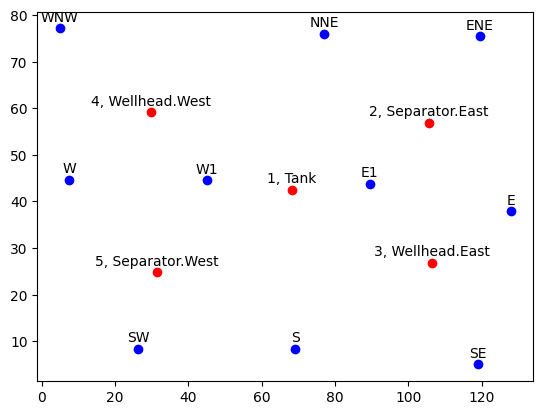

In [228]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

fig,ax = plt.subplots()
ax.scatter(source_points[:,0],source_points[:,1],color='red')
ax.scatter(sensor_points[:,0],sensor_points[:,1],color='blue')

labels = sensor_names
for i, label in enumerate(labels):
    plt.annotate(label, (sensor_points[i,0],sensor_points[i,1]), textcoords="offset points", xytext=(0,5), ha='center')

labels = source_names
for i in range(len(source_points)):
    plt.annotate(f'{i+1}, {labels[i]}', (source_points[i,0],source_points[i,1]), textcoords="offset points", xytext=(0,5), ha='center')

tensor(3.2948e-07)
10


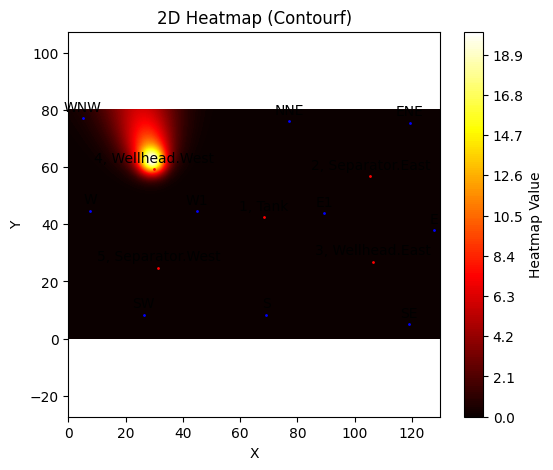

In [229]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
print(torch.min(result))
# Convert to NumPy
print(num_t)
t_step=num_t-2
x = XX[XX.shape[0]//num_t*t_step:XX.shape[0]//num_t*(t_step+1),0].squeeze().numpy()
y = XX[XX.shape[0]//num_t*t_step:XX.shape[0]//num_t*(t_step+1),1].squeeze().numpy()
z = result[result.shape[0]//num_t*t_step:result.shape[0]//num_t*(t_step+1)].squeeze().numpy()
# Create grid
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 200),
    np.linspace(y.min(), y.max(), 200)
)

# Interpolate to the grid
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Plot with contourf
plt.figure(figsize=(6, 5))
# cont = plt.contourf(grid_x, grid_y, grid_z, levels=100, cmap='hot')
cont = plt.contourf(grid_x, grid_y, grid_z, levels=200, cmap='hot')

plt.scatter(source_points[:,0],source_points[:,1],color='red',s=1)
plt.scatter(sensor_points[:,0],sensor_points[:,1],color='blue',s=1)

labels = sensor_names
for i, label in enumerate(labels):
    plt.annotate(label, (sensor_points[i,0],sensor_points[i,1]), textcoords="offset points", xytext=(0,5), ha='center')

labels = source_names
for i in range(len(source_points)):
    plt.annotate(f'{i+1}, {labels[i]}', (source_points[i,0],source_points[i,1]), textcoords="offset points", xytext=(0,5), ha='center')
plt.colorbar(cont, label="Heatmap Value")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Heatmap (Contourf)")
plt.axis("equal")
plt.show()


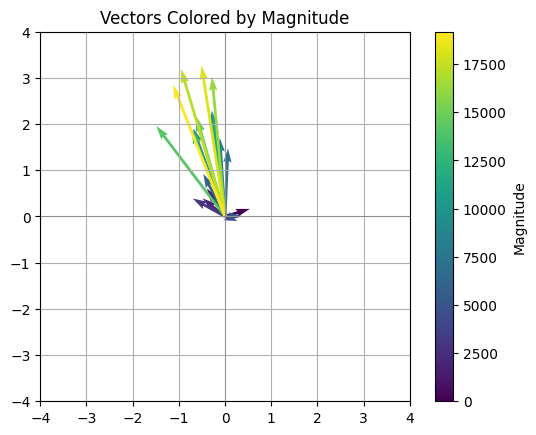

tensor([-1.7036e+09, -1.7036e+09, -1.7036e+09, -1.7036e+09, -1.7036e+09,
        -1.7036e+09, -1.7036e+09, -1.7036e+09, -1.7036e+09, -1.7036e+09,
        -1.7036e+09, -1.7036e+09, -1.7036e+09, -1.7036e+09, -1.7036e+09,
        -1.7036e+09, -1.7036e+09, -1.7036e+09, -1.7036e+09, -1.7036e+09])


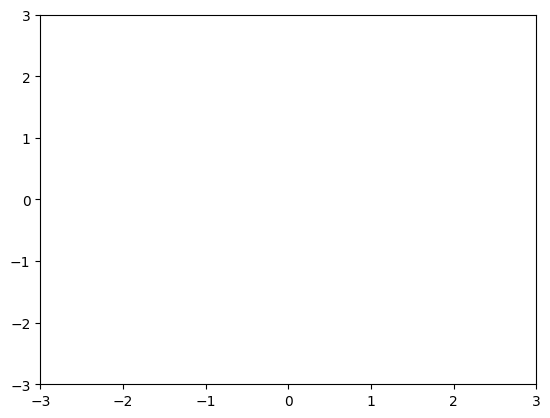

In [230]:
import matplotlib.pyplot as plt
import numpy as np
tt = torch.linspace(pm.t0,pm.t_max,20)
x = wind_x(tt)
y = wind_y(tt)
# Points as vectors

# Third variable, e.g., magnitude or other feature

# Origins at (0,0)
origin = np.zeros((tt.shape[0], 2))

# Plot
plt.figure()
quiv = plt.quiver(origin[:, 0], origin[:, 1], x, y,
                  tt - pm.t0 , angles='xy', scale_units='xy', scale=1, cmap='viridis')

# Add colorbar
plt.colorbar(quiv, label="Magnitude")

# Axes and formatting
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.gca().set_aspect('equal')
plt.grid(True)
plt.title("Vectors Colored by Magnitude")
plt.show()

plt.xlim(-3,3)
plt.ylim(-3,3)

print(tt - start_time_utc_seconds)

C:\Users\andyh\AppData\Local\Temp\ipykernel_34748\14697068.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_x = torch.tile(torch.tensor(sensor_points).reshape(-1,1,3),(1,obs_t.shape[0],1)).reshape(-1,3)
C:\Users\andyh\AppData\Local\Temp\ipykernel_34748\14697068.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


10


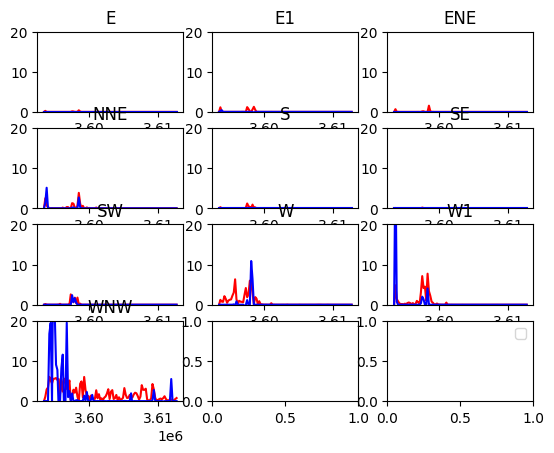

In [231]:
fig, ax  = plt.subplots(num_sensors//3+1,3)
obs_t = torch.linspace(pm.t0,pm.t_max,100).reshape(-1,1)
t = obs_t
num_obs = obs_t.shape[0]
obs_x = torch.tile(torch.tensor(sensor_points).reshape(-1,1,3),(1,obs_t.shape[0],1)).reshape(-1,3)
obs_t = obs_t.repeat(num_sensors,1)
print(num_sensors)

result_final = pm.simulate_concentration(obs_x,obs_t)
M_torch = pim.Q
for i in range(num_sensors):
    ax[i//3,i%3].set_title(sensor_names[i])
    tt = obs_t
    ax[i//3,i%3].plot(t,(result_final[num_obs*i:(num_obs*(i+1)),:]).view(-1) ,color='red',label='predicted')
    ax[i//3,i%3].plot(t,sensor_values_fn[sensor_names[i]](t),color='blue',label='true')
    ax[i//3,i%3].set_ylim(0,20)
    plt.legend()
    

In [232]:
print(pm.q)

tensor([[-8.8660e-10],
        [ 1.0954e-10],
        [ 6.6553e-10],
        [ 1.9244e+03],
        [-2.5809e-09],
        [ 3.2948e-07]])


In [ ]:
print(result.max())

tensor(4.7035)
